In [1]:
import torch
import torch.nn as nn
import torch.optim as optm
import os
import json
from metrics_amazon import CM, f1_score0, f1_score1, Recall, Precision, ACC
import numpy as np
from preprocess import load_tif_image, extract_temporal_sorted_patches, extract_sorted_patches, divide_pred_windows
import matplotlib.pyplot as plt

import imageio
import matplotlib.animation as animation
from IPython.display import HTML


/home/thiago/python-envs/base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def display_video(video):
    fig, ax = plt.subplots()
    ims = []
    for i in range(video.shape[0]):
        im = ax.imshow(video[i], animated=True)
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    plt.colorbar(im, ax=ax)
    plt.close()
    ani.save('animation.mp4', writer='ffmpeg')
    # return HTML(ani.to_jshtml())
    return HTML(ani.to_html5_video())

In [3]:
experiment = 'exp02'

preds = np.load(os.path.join('work_dirs', experiment, 'preds.npy'))
print(preds.shape)
# preds_reconstructed = np.load(os.path.join('work_dirs', experiment, 'img_reconstructed.npy'))
# def_preds_reconstructed = np.load(os.path.join('work_dirs', experiment, 'def_img_reconstructed.npy'))

mean_std = np.load(os.path.join('work_dirs', experiment, 'mean_std.npy'))

training_config = json.load(open(os.path.join('work_dirs', experiment, 'model_training.json')))
print(training_config)

(19632, 2, 2, 128, 128)
{'pre_seq_length': 4, 'aft_seq_length': 2, 'total_length': 6, 'batch_size': 64, 'val_batch_size': 64, 'epoch': 100, 'lr': 5e-05, 'metrics': ['mse', 'mae'], 'ex_name': 'exp02', 'in_shape': [4, 1, 128, 128], 'patience': 10, 'delta': 0.0001, 'amazon_mask': True, 'pixel_size': '1K', 'patch_size': 128, 'window_size': 6, 'overlap': 0.15, 'loss': 'focal', 'aux_metrics': ['CM'], 'normalize': True, 'scheduler_step_size': 1, 'scheduler_decay_factor': 0.95, 'optmizer': 'sgd', 'sgd_momentum': 0.8, 'focal_gamma': 4.5, 'focal_alpha': 0.05}


In [9]:
# Load Test Image
deter_img = load_tif_image('data/DETER/deter_increments_1km_1week.tif')

mask = load_tif_image('data/IBAMA_INPE/1K/tiff_filled/mask.tif')
mask = mask[:deter_img.shape[1], :deter_img.shape[2]]

# deter_img[:, mask == 0] = -1
# deter_img[deter_img > 0] = 1
deter_img_test = deter_img[(96 + 48):(96 + 48 + 48)]
del deter_img

In [9]:
print(deter_img_test.shape)

(63, 2333, 3005)


In [5]:
def_preds_reconstructed = np.load('work_dirs/exp02/def_preds_reconstructed.npy')

In [10]:
print(def_preds_reconstructed.shape)
for i in range(def_preds_reconstructed.shape[0]):
    print(i)
    def_preds_reconstructed[i][mask == 0] = -1
    # display_video(def_preds_reconstructed[i])

(12, 2333, 3005)
0
1
2
3
4
5
6
7
8
9
10
11


In [14]:
def_preds_reconstructed2 = def_preds_reconstructed.copy()
def_preds_reconstructed2[def_preds_reconstructed2 > 0.3] = 1
display_video(def_preds_reconstructed2)

In [29]:
plt.show()
# with open('animation.html', 'w') as f:
#     f.write(str(html_video))

In [5]:
print(deter_img_test.shape)
print(mask.shape)

(48, 2333, 3005)
(2333, 3005)


In [6]:
test_patches = extract_temporal_sorted_patches(deter_img_test, training_config['patch_size'])
print('Test Patches:', test_patches.shape)

mask_test_patches = extract_sorted_patches(mask, training_config['patch_size'])
print('Mask Test Patches:', mask_test_patches.shape)

Test Patches: (48, 414, 128, 128)
Mask Test Patches: (414, 128, 128)


In [7]:
test_files, mask_test_files, _ = divide_pred_windows(test_patches, min_def=0, window_size=training_config['total_length'],\
    mask_patches=mask_test_patches)
print(f'Test shape: {test_files.shape} - {mask_test_files.shape}')
del test_patches, mask_test_patches

Dividing in prediction windows:   0%|          | 0/19632 [00:00<?, ?it/s]

/home/thiago/python-envs/base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thiago/python-envs/base/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Dividing in prediction windows: 100%|██████████| 19632/19632 [00:02<00:00, 8712.29it/s] 


0 Skipped Images
Test shape: (19632, 6, 128, 128) - (19632, 128, 128)


In [18]:
min_def = 0.005
skip_count = 0
def_indexes = []
def_means = []
for i in range(test_files.shape[0]):
    # print(f'Processing {i} of {test_files.shape[0]}')
    # test_files[i] = (test_files[i] - mean_std[0])/mean_std[1]
    patches = test_files[i]
    labels = patches[-2:]
    _label = labels[:, mask_test_files[i] == 1]
    _label[_label > 0] = 1
    # print(_label.shape)
    mean = np.mean(_label, axis=(0, 1))
    # 1/0
    # Deal with Nan
    if np.isnan(mean): mean = 0
    # if np.isnan(mean[0]): mean[0] = 0
    # if np.isnan(mean[1]): mean[1] = 0
    # if mean[0] < min_def or mean[1] < min_def:
    if mean < min_def:
    # if mean[0] + mean[1] < min_def:
        skip_count += 1
        # print('here')
        continue
    # print(mean.shape)
    # print(mean[0] + mean[1])
    def_indexes.append(i)
    def_means.append(mean)
    # patches_pred = preds[i, 1]
    # patches_pred[:, mask_test_files[i] == 0] = -1
    # patches[:, mask_test_files[i] == 0] = -1
    # print('finished')
    # break
print(f'Skipped {skip_count} patches')

Skipped 79147 patches


In [19]:
print(patches.shape)
# print(patches_pred.shape)
print(len(def_indexes))
print(len(def_means))
print(def_indexes)

(6, 64, 64)
101
101
[36700, 36701, 36705, 36706, 36714, 36715, 36718, 36719, 36760, 36761, 36762, 36846, 36847, 36895, 36896, 37073, 37074, 37081, 37082, 37120, 37121, 37162, 37163, 37170, 37171, 37176, 37177, 37207, 37208, 37303, 37304, 37404, 37405, 37565, 37566, 37671, 37672, 37673, 37674, 37717, 37718, 38174, 38175, 38266, 38398, 38399, 38408, 38412, 38413, 38455, 38456, 38534, 38535, 38541, 38542, 38543, 38577, 38578, 38579, 38580, 38582, 38583, 38585, 38586, 38587, 38588, 38630, 38631, 38632, 38642, 38643, 38674, 38719, 38720, 38721, 38723, 38724, 38725, 38726, 38767, 38768, 38773, 38774, 38776, 38777, 38778, 38820, 38821, 38822, 38823, 38824, 38975, 38976, 39021, 39022, 39061, 39062, 39413, 39414, 39459, 39460]


38175


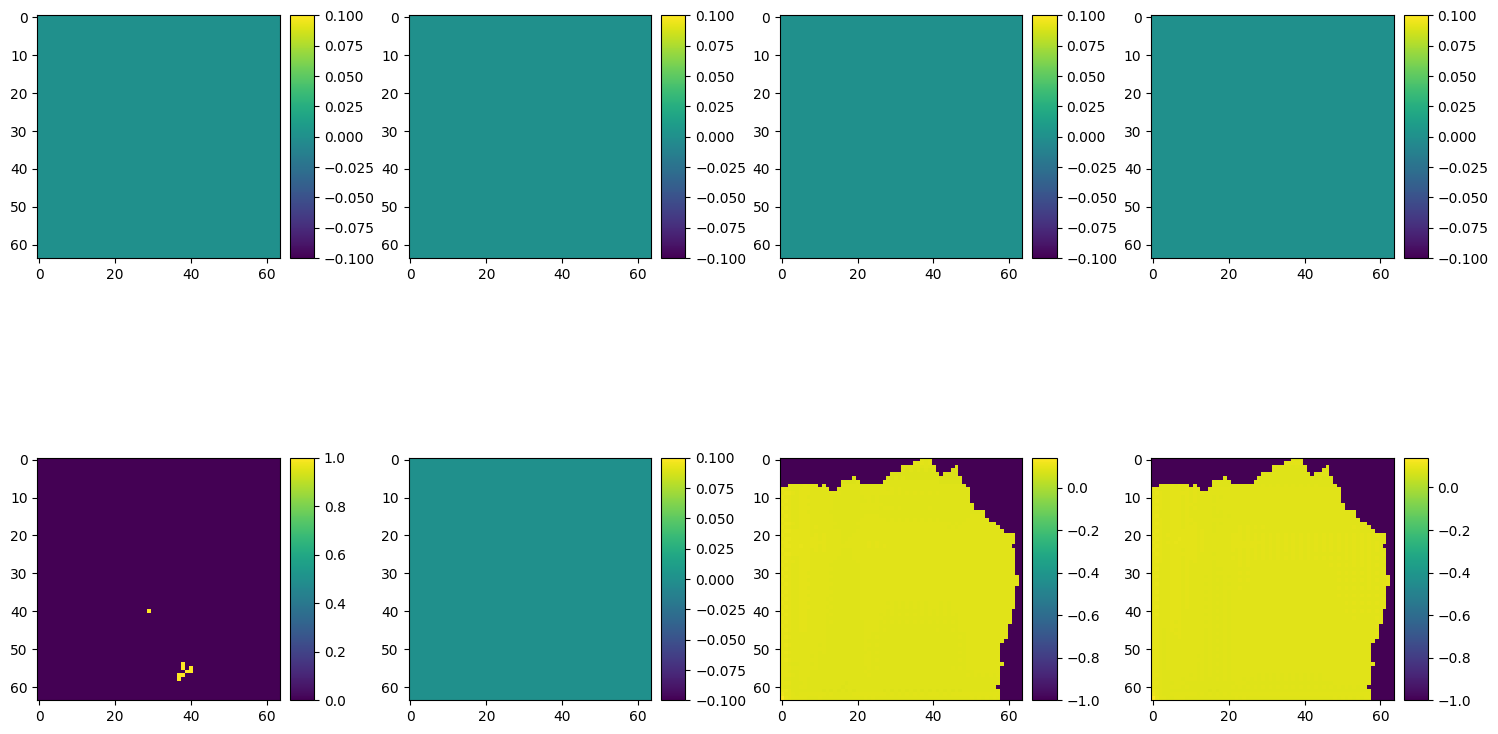

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Pick a random number from the list
index = np.random.choice(def_indexes)
# cont=0
# cont -= -1
# index = def_indexes[cont]
print(index)
patches_pred = preds[index, 1]
patches = test_files[index]

patches_pred[:, mask_test_files[index] == 0] = -1

patches[:, mask_test_files[index] == 0] = -1
patches[patches > 0] = 1
patches[patches < 0] = 0
    
fig, axs = plt.subplots(2, 4, figsize=(15, 10))

patches_plot = np.concatenate((patches, patches_pred), axis=0)
for i in range(2):
    for j in range(4):
        im = axs[i, j].imshow(patches_plot[i*4 + j])
        divider = make_axes_locatable(axs[i, j])
        cax = divider.append_axes("right", size="10%", pad=0.1)
        fig.colorbar(im, cax=cax)
        # axs[i, j].axis('off')

plt.tight_layout()
plt.show()

In [8]:
#apply pred mask
for i in range(preds.shape[0]):
    # preds[i, :, patches_pred[i] == 1] = -1
    # patches_pred = preds[i, 1]
    # print(preds[i].shape)
    preds[i, :, :, mask_test_files[i] == 0] = -1

In [58]:
print(preds.shape)

(79248, 2, 2, 64, 64)


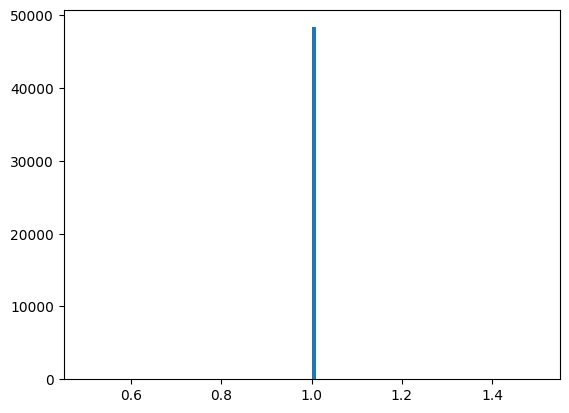

In [9]:
# def_preds = preds[:, 1]
# def_preds = def_preds[def_preds != -1]
test_files2 = test_patches.copy()
test_files2[test_files2 > 0] = 1
test_files2[test_files2 <= 0] = 0
test_files3 = test_files2[test_files2 == 1]
# Plot histogram
plt.hist(test_files3.reshape(-1), bins=100)
plt.show()

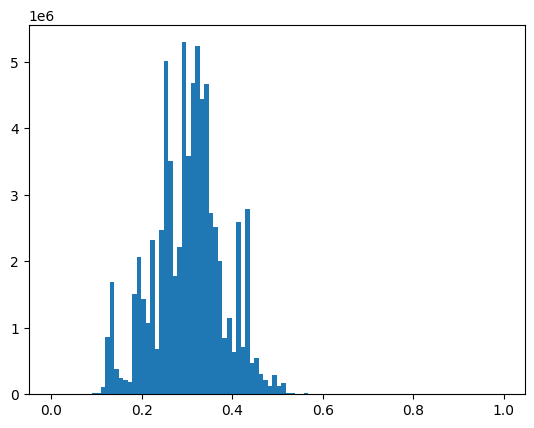

In [9]:
def_preds = preds[:, 1]
def_preds = def_preds[def_preds != -1]

# Plot histogram
plt.hist(def_preds, bins=100)
plt.show()

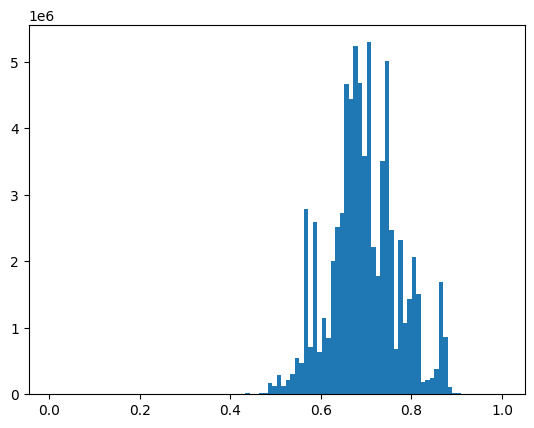

In [10]:
no_def_preds = preds[:, 0]
no_def_preds = no_def_preds[no_def_preds != -1]

# Plot histogram
plt.hist(no_def_preds, bins=100)
plt.show()